# SFD-Only Analysis

This notebook analyzes the results from our SetBERT models trained only on the real SFD data.

In [1]:
import deepctx as dc
import dotenv
from IPython.display import clear_output, display
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pickle
from scipy.spatial.distance import cdist
from sklearn.manifold import MDS
from sklearn.metrics import auc, precision_recall_curve, roc_curve, precision_recall_fscore_support, precision_score, recall_score
from sklearn.utils.extmath import stable_cumsum
import tensorflow as tf
from tqdm import tqdm
import wandb

from dnadb import fasta, sample, taxonomy
from deepdna.data.metrics import ppv_npv_curve
from deepdna.nn import data_generators as dg
from deepdna.nn.models import load_model, setbert

In [2]:
dotenv.load_dotenv("../.env")

True

In [3]:
pd.set_option('display.max_colwidth', None)

## Paths

In [4]:
log_path = Path(os.environ["log_path"]) / "sfd"

In [5]:
figure_path = (log_path / "figures")
figure_path.mkdir(exist_ok=True)

In [6]:
sfd_dataset_path = Path(os.environ["datasets_path"]) / "SFD"
sfd250_dataset_path = Path(os.environ["datasets_path"]) / "SFD250"

## Data

In [7]:
metadata = pd.read_csv(sfd_dataset_path / f"{sfd_dataset_path.name}.metadata.csv")

In [8]:
targets = dict(sorted(zip(metadata["swab_label"], metadata["oo_present"])))

In [9]:
positive_samples = set(t for t in targets if targets[t])
negative_samples = set(targets) - positive_samples
len(positive_samples), len(negative_samples)

(191, 547)

## Models

In [10]:
models = {
    "SetBERT (150-length)": "setbert-evaluate-sfd-only-classification-64d-150l",
    # "SetBERT (250-length)": "setbert-evaluate-sfd-only-classification-128d-250l",
    "SetBERT (Shallow-Trained, 150-length)": "setbert-evaluate-sfd-only-classification-shallow-64d-150l",
    # "SetBERT (Shallow, 250-length)": "setbert-evaluate-sfd-only-classification-shallow-128d-250l",
}

---

## Classification Performance by Model

In [11]:
ancom_model_npv_ppv = (0.903, 0.364)

For each model, load the resulting predictions for each of the test samples.

In [12]:
results = {}
for model_name, model in models.items():
    results[model_name] = {"labels": [], "predictions": []}
    for sample_name in tqdm(sorted(targets)):
        label = targets[sample_name]
        predictions = []
        for path in sorted((log_path / model).glob(f"{sample_name}.*")):
            values = np.load(path)
            predictions.append(values["result"])
        if len(predictions) > 0:
            results[model_name]["labels"].append(label)
            results[model_name]["predictions"].append(np.mean(predictions))
    results[model_name]["labels"] = np.array(results[model_name]["labels"])
    results[model_name]["predictions"] = np.array(results[model_name]["predictions"])

100%|██████████| 738/738 [00:06<00:00, 111.35it/s]


In [15]:
for model_name, result in results.items():
    y_true = results[model_name]["labels"]
    y_pred = results[model_name]["predictions"].flatten()
    ppv, npv, thresholds = ppv_npv_curve(y_true, y_pred, pad=True)

    i = np.argmin(np.abs(ppv - npv))

    print(ppv[i], npv[i])

    break

0.9947089947089947 0.9927404718693285


Compute and plot the Precision-Recall curve.

Text(0.5, 1.0, 'Precision-Recall Curve')

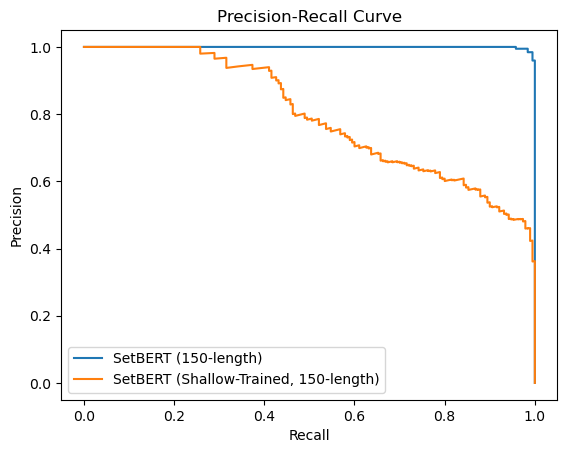

In [16]:
for model_name in results:
    y_true = results[model_name]["labels"]
    y_pred = results[model_name]["predictions"].flatten()
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    plt.plot(np.concatenate(([1.0], recall)), np.concatenate(([0.0], precision)), label=model_name)
plt.legend()
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")

Text(0.5, 1.0, 'PPV-NPV Curve')

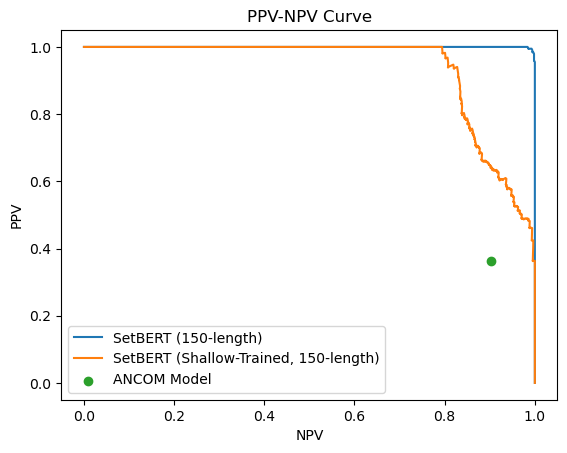

In [17]:
for model_name in results:
    y_true = results[model_name]["labels"]
    y_pred = results[model_name]["predictions"].flatten()
    ppv, npv, thresholds = ppv_npv_curve(y_true, y_pred, pad=True)
    plt.plot(np.concatenate(([1.0], npv)), np.concatenate(([0.0], ppv)), label=model_name)
    plt.scatter([], [])
plt.scatter([ancom_model_npv_ppv[0]], [ancom_model_npv_ppv[1]], label="ANCOM Model")
plt.legend()
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))
plt.xlabel("NPV")
plt.ylabel("PPV")
plt.title("PPV-NPV Curve")

### Manuscript PPV Vs. NPV Plot

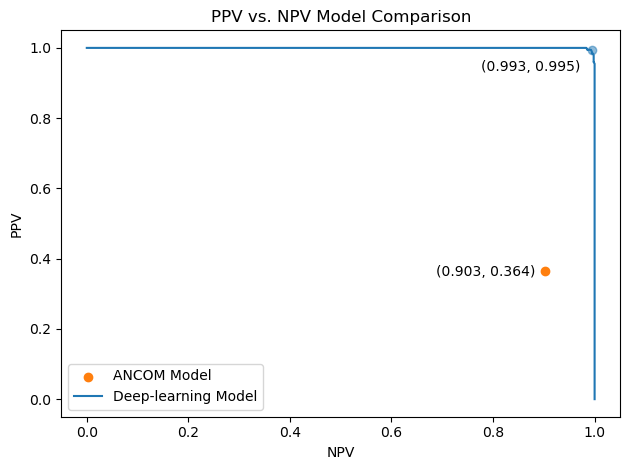

In [18]:
model_name = "SetBERT (150-length)"
y_true = results[model_name]["labels"]
y_pred = results[model_name]["predictions"].flatten()
ppv, npv, thresholds = ppv_npv_curve(y_true, y_pred, pad=True)
i = np.argmin(np.abs(ppv - npv))
plt.scatter([ppv[i]], [npv[i]], alpha=0.5)
plt.scatter([ancom_model_npv_ppv[0]], [ancom_model_npv_ppv[1]], label=f"ANCOM Model")
plt.text(
    *(np.array([-0.02, -0.05]) + [npv[i], ppv[i]]),
    f"({npv[i]:.3f}, {ppv[i]:.3f})",
    horizontalalignment="right",
    verticalalignment="center")
plt.text(
    *(np.array([-0.02, -0.003]) + ancom_model_npv_ppv),
    f"({ancom_model_npv_ppv[0]}, {ancom_model_npv_ppv[1]})",
    horizontalalignment="right",
    verticalalignment="center")
plt.plot(np.concatenate(([1.0], npv)), np.concatenate(([0.0], ppv)), label="Deep-learning Model")
plt.legend()
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))
plt.xlabel("NPV")
plt.ylabel("PPV")
plt.title("PPV vs. NPV Model Comparison")
plt.tight_layout()
plt.savefig(figure_path / "SetBERT_Vs_ANCOM_PPV_NPV.tif", dpi=300)
plt.show()

---

## Pre-trained vs. Fine-tuned Embeddings by Model

For each model, load and group the sample embedding vectors by SFD presence.

In [19]:
embeddings = {} # [model_name, pretrain|finetune, positive|negative]
for model_name, model in models.items():
    print(model_name)
    embeddings[model_name] = {
        "pretrain": {
            "positive": [],
            "negative": []
        },
        "finetune": {
            "positive": [],
            "negative": []
        }
    }
    for sample_name, is_positive in tqdm(sorted(targets.items())):
        positivity = "positive" if is_positive else "negative"
        for path in sorted((log_path / model).glob(f"{sample_name}*")):
            values = np.load(path)
            embeddings[model_name]["pretrain"][positivity].append(values["pretrain_embedding"])
            embeddings[model_name]["finetune"][positivity].append(values["finetune_embedding"])
            break
    for training, positivity in product(("pretrain", "finetune"), ("positive", "negative")):
        embeddings[model_name][training][positivity] = np.array(embeddings[model_name][training][positivity])

SetBERT (150-length)


100%|██████████| 738/738 [00:03<00:00, 237.25it/s]


SetBERT (Shallow-Trained, 150-length)


100%|██████████| 738/738 [00:03<00:00, 233.33it/s]


Compute the pair-wise distances between each of the embedding vectors. The positive and negative embeddings are concatenated in this order.

In [20]:
metric = "cityblock"
distances = {} # [model_name, pretrain|finetune]
for model_name in tqdm(embeddings):
    distances[model_name] = {}
    for training in embeddings[model_name]:
        positive_and_negative = np.concatenate((
            embeddings[model_name][training]["positive"],
            embeddings[model_name][training]["negative"]))
        distances[model_name][training] = cdist(positive_and_negative, positive_and_negative)

100%|██████████| 2/2 [00:00<00:00, 48.16it/s]


Using the distance matrices, use MDS to find the principal components of the embeddings to plot in a lower dimension.

In [21]:
mds_embeddings = {} # [model_name, pretrain|finetune, positive|negative]
for model_name in tqdm(distances):
    mds_embeddings[model_name] = {}
    for training in distances[model_name]:
        mds = MDS(dissimilarity="precomputed")
        points = mds.fit_transform(distances[model_name][training])
        split_index = len(embeddings[model_name][training]["positive"])
        mds_embeddings[model_name][training] = {
            "positive": points[:split_index],
            "negative": points[split_index:]
        }

100%|██████████| 2/2 [00:25<00:00, 12.77s/it]


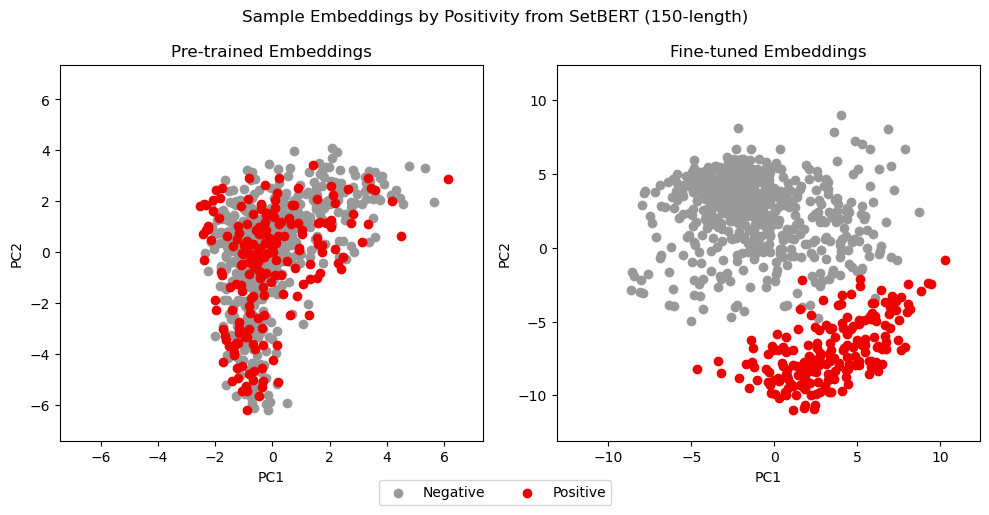

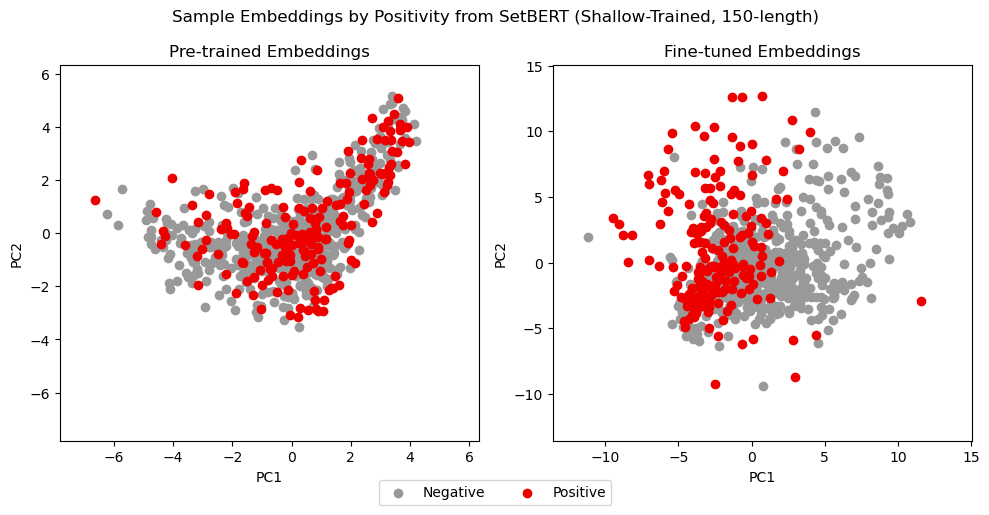

In [22]:
subtitles = {
    "pretrain": "Pre-trained Embeddings",
    "finetune": "Fine-tuned Embeddings"
}
for model_name in embeddings:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    for i, training in enumerate(mds_embeddings[model_name], start=1):
        plt.subplot(1, 2, i)
        xymin = np.min((
            np.min(mds_embeddings[model_name][training]["positive"]),
            np.min(mds_embeddings[model_name][training]["negative"])))
        xymax = np.max((
            np.max(mds_embeddings[model_name][training]["positive"]),
            np.max(mds_embeddings[model_name][training]["negative"])))
        padding = 0.1*(xymax - xymin)
        plt.scatter(*mds_embeddings[model_name][training]["negative"].T, label="Negative", color="#999999")
        plt.scatter(*mds_embeddings[model_name][training]["positive"].T, label="Positive", color="#ee0000")
        plt.title(subtitles[training])
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.xlim((xymin - padding, xymax + padding))
        plt.ylim((xymin - padding, xymax + padding))

    fig.suptitle(f"Sample Embeddings by Positivity from {model_name}")
    fig.legend(*axs[0].get_legend_handles_labels(), loc="lower center", bbox_to_anchor=(0.5, -0.025, 0.0, 0.0), ncol=3)
    plt.tight_layout()
    plt.show()

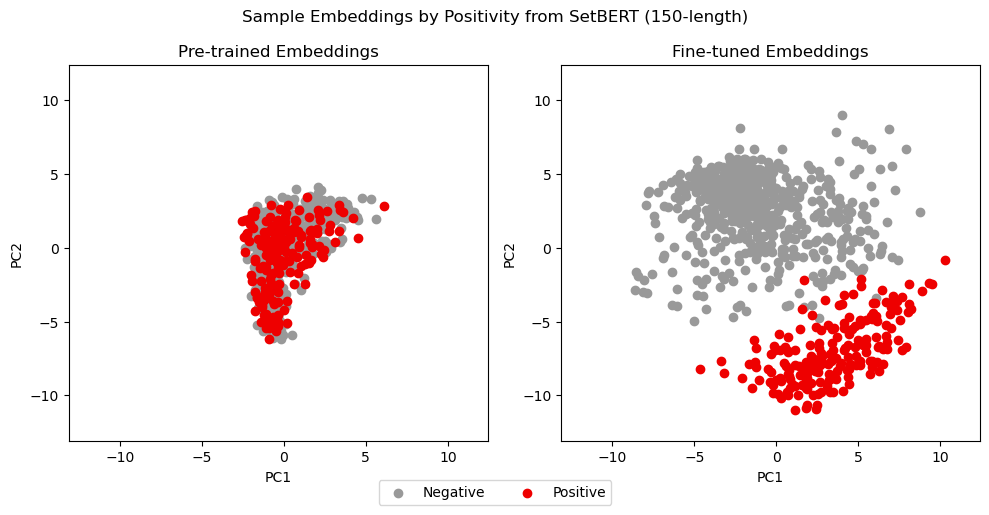

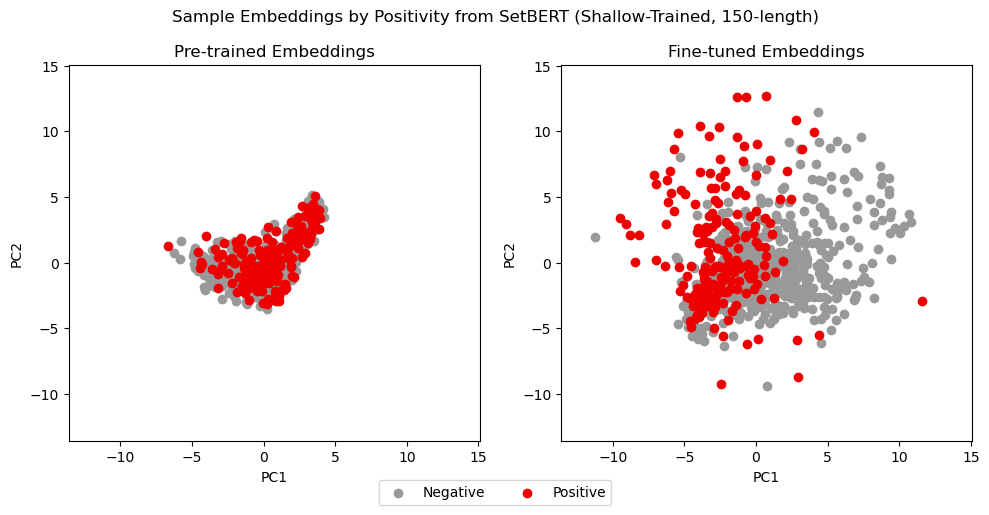

In [23]:
subtitles = {
    "pretrain": "Pre-trained Embeddings",
    "finetune": "Fine-tuned Embeddings"
}
for model_name in embeddings:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    xymin = np.inf
    xymax = -np.inf
    for training in mds_embeddings[model_name]:
        xymin = np.min((
            xymin,
            np.min(mds_embeddings[model_name][training]["positive"]),
            np.min(mds_embeddings[model_name][training]["negative"])))
        xymax = np.max((
            xymax,
            np.max(mds_embeddings[model_name][training]["positive"]),
            np.max(mds_embeddings[model_name][training]["negative"])))
    for i, training in enumerate(mds_embeddings[model_name], start=1):
        plt.subplot(1, 2, i)
        padding = 0.1*(xymax - xymin)
        plt.scatter(*mds_embeddings[model_name][training]["negative"].T, label="Negative", color="#999999")
        plt.scatter(*mds_embeddings[model_name][training]["positive"].T, label="Positive", color="#ee0000")
        plt.title(subtitles[training])
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.xlim((xymin - padding, xymax + padding))
        plt.ylim((xymin - padding, xymax + padding))

    fig.suptitle(f"Sample Embeddings by Positivity from {model_name}")
    fig.legend(*axs[0].get_legend_handles_labels(), loc="lower center", bbox_to_anchor=(0.5, -0.025, 0.0, 0.0), ncol=3)
    plt.tight_layout()
    plt.show()

### Manuscript MDS Plot

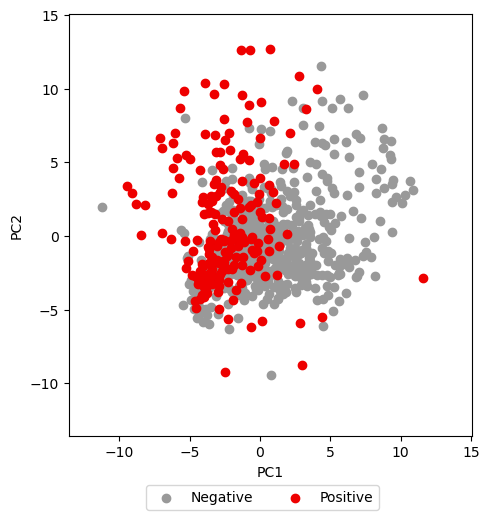

In [76]:
model_name = "SetBERT (Shallow-Trained, 150-length)"
training = "finetune"
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
xymin = np.min((
    np.min(mds_embeddings[model_name][training]["positive"]),
    np.min(mds_embeddings[model_name][training]["negative"])))
xymax = np.max((
    np.max(mds_embeddings[model_name][training]["positive"]),
    np.max(mds_embeddings[model_name][training]["negative"])))
padding = 0.1*(xymax - xymin)
plt.scatter(*mds_embeddings[model_name][training]["negative"].T, label="Negative", color="#999999")
plt.scatter(*mds_embeddings[model_name][training]["positive"].T, label="Positive", color="#ee0000")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xlim((xymin - padding, xymax + padding))
plt.ylim((xymin - padding, xymax + padding))
fig.legend(*ax.get_legend_handles_labels(), loc="lower center", bbox_to_anchor=(0.535, -0.045, 0.0, 0.0), ncol=3)
plt.tight_layout()
plt.savefig(figure_path / "SetBERT_MDS.tif", dpi=300, bbox_inches='tight')
plt.show()

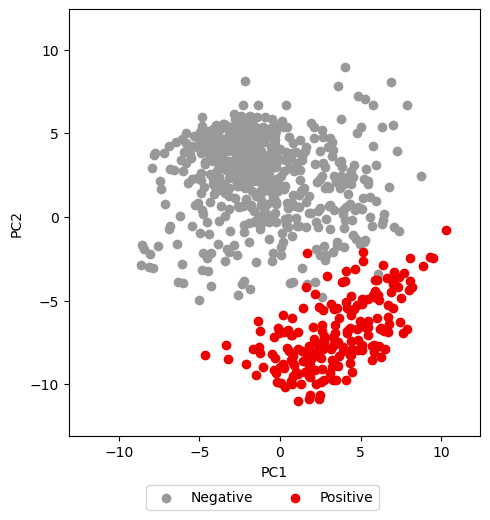

In [73]:
model_name = "SetBERT (150-length)"
training = "finetune"
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
xymin = np.min((
    np.min(mds_embeddings[model_name][training]["positive"]),
    np.min(mds_embeddings[model_name][training]["negative"])))
xymax = np.max((
    np.max(mds_embeddings[model_name][training]["positive"]),
    np.max(mds_embeddings[model_name][training]["negative"])))
padding = 0.1*(xymax - xymin)
plt.scatter(*mds_embeddings[model_name][training]["negative"].T, label="Negative", color="#999999")
plt.scatter(*mds_embeddings[model_name][training]["positive"].T, label="Positive", color="#ee0000")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xlim((xymin - padding, xymax + padding))
plt.ylim((xymin - padding, xymax + padding))
fig.legend(*ax.get_legend_handles_labels(), loc="lower center", bbox_to_anchor=(0.535, -0.045, 0.0, 0.0), ncol=3)
plt.tight_layout()
plt.savefig(figure_path / "SetBERT_MDS.tif", dpi=300, bbox_inches='tight')
plt.show()

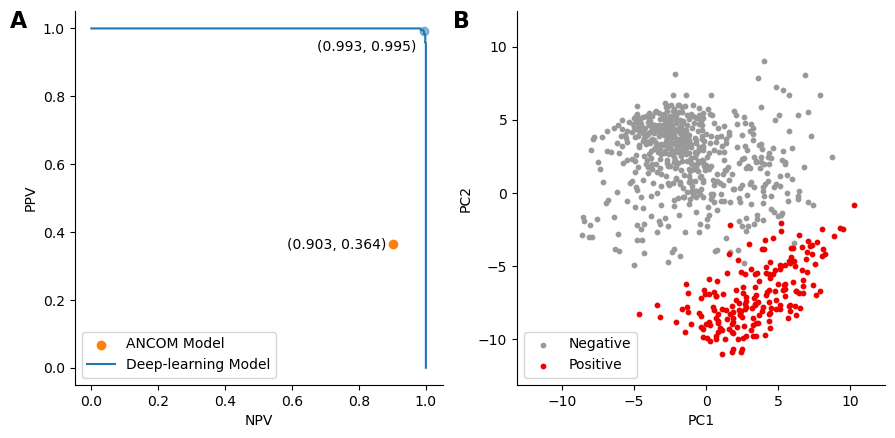

In [72]:
model_name = "SetBERT (150-length)"
training = "finetune"
fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))

plt.subplot(1, 2, 1)
y_true = results[model_name]["labels"]
y_pred = results[model_name]["predictions"].flatten()
ppv, npv, thresholds = ppv_npv_curve(y_true, y_pred, pad=True)
i = np.argmin(np.abs(ppv - npv))
plt.scatter([ppv[i]], [npv[i]], alpha=0.5)
plt.scatter([ancom_model_npv_ppv[0]], [ancom_model_npv_ppv[1]], label=f"ANCOM Model")
plt.text(
    *(np.array([-0.02, -0.05]) + [npv[i], ppv[i]]),
    f"({npv[i]:.3f}, {ppv[i]:.3f})",
    horizontalalignment="right",
    verticalalignment="center")
plt.text(
    *(np.array([-0.02, -0.003]) + ancom_model_npv_ppv),
    f"({ancom_model_npv_ppv[0]}, {ancom_model_npv_ppv[1]})",
    horizontalalignment="right",
    verticalalignment="center")
plt.plot(np.concatenate(([1.0], npv)), np.concatenate(([0.0], ppv)), label="Deep-learning Model")
plt.legend()
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))
plt.xlabel("NPV")
plt.ylabel("PPV")
# plt.title("PPV vs. NPV Model Comparison")
trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
plt.text(-0.1, 0.93, "A", transform=axs[0].transAxes + trans, fontsize="16", fontweight="bold")
axs[0].spines[['right', 'top']].set_visible(False)

plt.subplot(1, 2, 2)
xymin = np.min((
    np.min(mds_embeddings[model_name][training]["positive"]),
    np.min(mds_embeddings[model_name][training]["negative"])))
xymax = np.max((
    np.max(mds_embeddings[model_name][training]["positive"]),
    np.max(mds_embeddings[model_name][training]["negative"])))
padding = 0.1*(xymax - xymin)
plt.scatter(*mds_embeddings[model_name][training]["negative"].T, label="Negative", color="#999999", s=10)
plt.scatter(*mds_embeddings[model_name][training]["positive"].T, label="Positive", color="#ee0000", s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xlim((xymin - padding, xymax + padding))
plt.ylim((xymin - padding, xymax + padding))
# plt.title("Sample Embeddings PCA")
plt.legend(loc="lower left")
trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
plt.text(-0.1, 0.93, "B", transform=axs[1].transAxes + trans, fontsize="16", fontweight="bold")
axs[1].spines[['right', 'top']].set_visible(False)
# fig.legend(*ax.get_legend_handles_labels(), loc="lower center", bbox_to_anchor=(0.535, -0.045, 0.0, 0.0), ncol=3)

plt.tight_layout()
plt.savefig(figure_path / "SetBERT_Performance.tif", dpi=300, bbox_inches='tight')
plt.show()


---

## Associated Taxa for Predictions (Unnormalized Attention Scores)

Open the associated taxonomy database containing the assignmened taxa.

In [77]:
tax_db = taxonomy.TaxonomyDb(sfd_dataset_path / "SFD.tax.tsv.db")

For each model, compute the number of occurrances and total score of each taxonomy label per sample.

In [156]:
taxa_scores = {}
taxa_abundances = {}
for model_name, model in models.items():
    print(model_name)
    taxa_scores[model_name] = {}
    taxa_abundances[model_name] = {}
    for sample_name in tqdm(sorted(targets)):
        paths = sorted((log_path / model).glob(f"{sample_name}.*"))
        if len(paths) == 0:
            continue
        taxa_scores[model_name][sample_name] = {}
        taxa_abundances[model_name][sample_name] = {}
        for path in paths:
            fasta_entries = fasta.entries((sfd_dataset_path / "test" / path.name).with_suffix(".fasta"))
            shift_scores = np.load(path)["shift_scores"]
            shift_scores = shift_scores[:,1:,1:]        # remove class token
            shift_scores = np.sum(shift_scores, axis=0) # aggregate across transformers blocks
            shift_scores = np.sum(shift_scores, axis=0) # aggregate across attention rows
            for entry, score in zip(fasta_entries, shift_scores):
                fasta_id = entry.extra # Real FASTA ID is stored in extra
                tax_label = tax_db.fasta_id_to_label(fasta_id)
                if tax_label not in taxa_scores[model_name][sample_name]:
                    taxa_scores[model_name][sample_name][tax_label] = 0.0
                    taxa_abundances[model_name][sample_name][tax_label] = 0
                taxa_scores[model_name][sample_name][tax_label] += score
                taxa_abundances[model_name][sample_name][tax_label] += 1
with open(log_path / "sfd_only_taxa.pkl", "wb") as f:
    pickle.dump((taxa_scores, taxa_abundances), f)

SetBERT (150-length)


100%|██████████| 738/738 [20:07<00:00,  1.64s/it]


SetBERT (Shallow-Trained, 150-length)


100%|██████████| 738/738 [19:52<00:00,  1.62s/it]


In [78]:
with open(log_path / "sfd_only_taxa.pkl", "rb") as f:
    taxa_scores, taxa_abundances = pickle.load(f)

Using the computed attention score by sample along with the number of occurrances of each label in each sample, compute the mean score of each taxonomy label grouped by sample positivity.

In [168]:
taxa_scores_by_positivity = {}
for model_name in taxa_scores:
    taxa_scores_by_positivity[model_name] = {"positive": {}, "negative": {}}
    num_positive = sum(targets[sample_name] for sample_name in taxa_scores[model_name])
    num_negative = sum(1 - targets[sample_name] for sample_name in taxa_scores[model_name])
    for sample_name in taxa_scores[model_name]:
        positivity = "positive" if targets[sample_name] else "negative"
        n = num_positive if targets[sample_name] else num_negative
        for label in taxa_scores[model_name][sample_name]:
            score = taxa_scores[model_name][sample_name][label]
            abundance = taxa_abundances[model_name][sample_name][label]
            normalized_score = score / abundance / n
            if label not in taxa_scores_by_positivity[model_name][positivity]:
                taxa_scores_by_positivity[model_name][positivity][label] = 0.0
            taxa_scores_by_positivity[model_name][positivity][label] += normalized_score

Rank the taxa by positive/negative sample for each model as Pandas dataframes.

In [169]:
ranked_taxa_by_positivity = {}
for model_name in taxa_scores_by_positivity:
    ranked_taxa_by_positivity[model_name] = {}
    for positivity in taxa_scores_by_positivity[model_name]:
        scores = taxa_scores_by_positivity[model_name][positivity]
        sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        data = map(lambda x: (*taxonomy.split_taxonomy(x[0], keep_empty=True), x[1]), sorted_scores)
        df = pd.DataFrame(data=data, columns=["Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Attention Score"])
        ranked_taxa_by_positivity[model_name][positivity] = df

In [170]:
for model_name in ranked_taxa_by_positivity:
    print(model_name)
    print("Positive:")
    display(ranked_taxa_by_positivity[model_name]["positive"][:10])
    print("Negative:")
    display(ranked_taxa_by_positivity[model_name]["negative"][:10])
    print("\n\n")

SetBERT (150-length)
Positive:


,Kingdom,Phylum,Class,Order,Family,Genus,Attention Score
0,Bacteria,Firmicutes,Bacilli,Bacillales,Family_XII,Exiguobacterium,28.903473
1,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,Paenarthrobacter,25.618158
2,Bacteria,Firmicutes,Bacilli,Lactobacillales,Enterococcaceae,Vagococcus,24.955500
3,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillales_unclassified,Bacillales_unclassified,24.916907
4,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Morganella,20.894436
5,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Luteimonas,20.687045
6,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Massilia,20.095791
7,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Thermomonas,16.371210
8,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,14.741423
9,Bacteria,Proteobacteria,Gammaproteobacteria,Aeromonadales,Aeromonadaceae,Aeromonas,13.713478


Negative:


,Kingdom,Phylum,Class,Order,Family,Genus,Attention Score
0,Bacteria,Firmicutes,Bacilli,Bacillales,Family_XII,Exiguobacterium,20.510172
1,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Massilia,18.274696
2,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillales_unclassified,Bacillales_unclassified,17.746014
3,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Luteimonas,13.598924
4,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Morganella,13.586533
5,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Thermomonas,13.276545
6,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,Paenarthrobacter,12.450008
7,Bacteria,Firmicutes,Bacilli,Lactobacillales,Enterococcaceae,Vagococcus,12.367988
8,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,12.260414
9,Bacteria,Firmicutes,Bacilli,Bacillales,Planococcaceae,Planococcaceae_unclassified,10.359901





SetBERT (Shallow-Trained, 150-length)
Positive:


,Kingdom,Phylum,Class,Order,Family,Genus,Attention Score
0,Bacteria,Planctomycetes,Planctomycetacia,Isosphaerales,Isosphaeraceae,Singulisphaera,19.056726
1,Bacteria,Bacteroidetes,Bacteroidia,Flavobacteriales,Weeksellaceae,Chryseobacterium,16.871715
2,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,15.518292
3,Bacteria,Bacteroidetes,Bacteroidia,Cytophagales,Hymenobacteraceae,Hymenobacter,14.754106
4,Bacteria,Chloroflexi,Chloroflexia,Thermomicrobiales,JG30-KF-CM45,JG30-KF-CM45_unclassified,13.835410
5,Bacteria,Bacteroidetes,Bacteroidia,Cytophagales,Spirosomaceae,Spirosoma,13.717045
6,Bacteria,Gemmatimonadetes,Gemmatimonadetes,Gemmatimonadales,Gemmatimonadaceae,Gemmatimonadaceae_unclassified,13.278798
7,Bacteria,Planctomycetes,Planctomycetacia,Gemmatales,Gemmataceae,Gemmata,13.057316
8,Bacteria,Planctomycetes,Planctomycetacia,Gemmatales,Gemmataceae,Gemmataceae_unclassified,12.203019
9,Bacteria,Planctomycetes,Planctomycetacia,Isosphaerales,Isosphaeraceae,Isosphaeraceae_unclassified,11.846375


Negative:


,Kingdom,Phylum,Class,Order,Family,Genus,Attention Score
0,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,24.283177
1,Bacteria,Bacteroidetes,Bacteroidia,Flavobacteriales,Weeksellaceae,Chryseobacterium,19.827458
2,Bacteria,Planctomycetes,Planctomycetacia,Isosphaerales,Isosphaeraceae,Singulisphaera,16.014725
3,Bacteria,Bacteroidetes,Bacteroidia,Cytophagales,Hymenobacteraceae,Hymenobacter,14.330270
4,Bacteria,Bacteroidetes,Bacteroidia,Cytophagales,Spirosomaceae,Spirosoma,13.888415
5,Bacteria,Planctomycetes,Planctomycetacia,Isosphaerales,Isosphaeraceae,Isosphaeraceae_unclassified,13.872372
6,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,Acinetobacter,12.564775
7,Bacteria,Bacteroidetes,Bacteroidia,Sphingobacteriales,Sphingobacteriaceae,Pedobacter,11.411034
8,Bacteria,Chloroflexi,Chloroflexia,Thermomicrobiales,JG30-KF-CM45,JG30-KF-CM45_unclassified,11.342555
9,Bacteria,Deinococcus-Thermus,Deinococci,Deinococcales,Deinococcaceae,Deinococcus,11.140672


---

## Associated Taxa for Predictions (Normalized Attention Scores)

Open the associated taxonomy database containing the assignmened taxa.

In [154]:
tax_db = taxonomy.TaxonomyDb(sfd_dataset_path / "SFD.tax.tsv.db")

For each model, compute the number of occurrances and total score of each taxonomy label per sample.

In [155]:
taxa_scores = {}
taxa_abundances = {}
for model_name, model in models.items():
    print(model_name)
    taxa_scores[model_name] = {}
    taxa_abundances[model_name] = {}
    for sample_name in tqdm(sorted(targets)):
        paths = sorted((log_path / model).glob(f"{sample_name}.*"))
        if len(paths) == 0:
            continue
        taxa_scores[model_name][sample_name] = {}
        taxa_abundances[model_name][sample_name] = {}
        for path in paths:
            fasta_entries = fasta.entries((sfd_dataset_path / "test" / path.name).with_suffix(".fasta"))
            shift_scores = np.load(path)["shift_scores"]
            shift_scores = shift_scores[:,1:,1:]        # remove class token
            shift_scores = np.sum(shift_scores, axis=1) # aggregate across attention rows
            shift_scores = shift_scores / np.expand_dims(np.max(np.abs(shift_scores), axis=1), 1)
            shift_scores = np.sum(shift_scores, axis=0) # aggregate across transformer blocks
            for entry, score in zip(fasta_entries, shift_scores):
                fasta_id = entry.extra # Real FASTA ID is stored in extra
                tax_label = tax_db.fasta_id_to_label(fasta_id)
                if tax_label not in taxa_scores[model_name][sample_name]:
                    taxa_scores[model_name][sample_name][tax_label] = 0.0
                    taxa_abundances[model_name][sample_name][tax_label] = 0
                taxa_scores[model_name][sample_name][tax_label] += score
                taxa_abundances[model_name][sample_name][tax_label] += 1
with open(log_path / "sfd_only_taxa_normalized.pkl", "wb") as f:
    pickle.dump((taxa_scores, taxa_abundances), f)

SetBERT (150-length)


100%|██████████| 738/738 [19:59<00:00,  1.63s/it]


SetBERT (Shallow-Trained, 150-length)


100%|██████████| 738/738 [20:09<00:00,  1.64s/it]


In [79]:
with open(log_path / "sfd_only_taxa_normalized.pkl", "rb") as f:
    taxa_scores, taxa_abundances = pickle.load(f)

Using the computed attention score by sample along with the number of occurrances of each label in each sample, compute the mean score of each taxonomy label grouped by sample positivity.

In [80]:
taxa_scores_by_positivity = {}
for model_name in taxa_scores:
    taxa_scores_by_positivity[model_name] = {"positive": {}, "negative": {}}
    num_positive = sum(targets[sample_name] for sample_name in taxa_scores[model_name])
    num_negative = sum(1 - targets[sample_name] for sample_name in taxa_scores[model_name])
    for sample_name in taxa_scores[model_name]:
        positivity = "positive" if targets[sample_name] else "negative"
        n = num_positive if targets[sample_name] else num_negative
        for label in taxa_scores[model_name][sample_name]:
            score = taxa_scores[model_name][sample_name][label]
            abundance = taxa_abundances[model_name][sample_name][label]
            normalized_score = score / abundance / n
            if label not in taxa_scores_by_positivity[model_name][positivity]:
                taxa_scores_by_positivity[model_name][positivity][label] = 0.0
            taxa_scores_by_positivity[model_name][positivity][label] += normalized_score

Rank the taxa by positive/negative sample for each model as Pandas dataframes.

In [81]:
ranked_taxa_by_positivity = {}
for model_name in taxa_scores_by_positivity:
    ranked_taxa_by_positivity[model_name] = {}
    for positivity in taxa_scores_by_positivity[model_name]:
        scores = taxa_scores_by_positivity[model_name][positivity]
        sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        data = map(lambda x: (*taxonomy.split_taxonomy(x[0], keep_empty=True), x[1]), sorted_scores)
        df = pd.DataFrame(data=data, columns=["Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Attention Score"])
        ranked_taxa_by_positivity[model_name][positivity] = df

Text(0.5, 1.0, 'Normalized Attention Scores by Taxa')

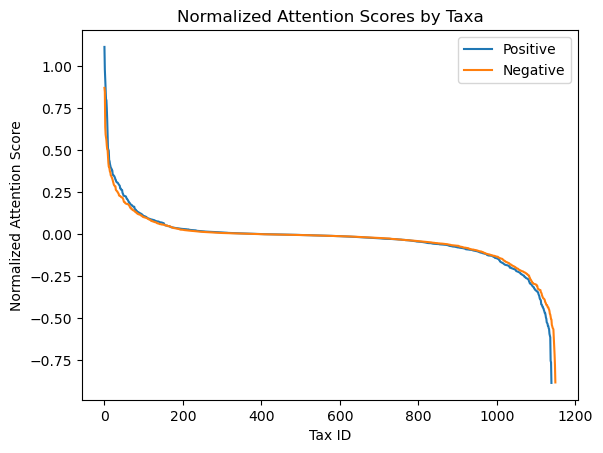

In [115]:
plt.plot(ranked_taxa_by_positivity["SetBERT (150-length)"]["positive"]["Attention Score"], label="Positive")
plt.plot(ranked_taxa_by_positivity["SetBERT (150-length)"]["negative"]["Attention Score"], label="Negative")
plt.xlabel("Tax ID")
plt.ylabel("Normalized Attention Score")
plt.legend()
plt.title("Normalized Attention Scores by Taxa")

In [106]:
negative_to_positive_shift = {}
for label in taxa_scores_by_positivity["SetBERT (150-length)"]["positive"]:
    if label not in taxa_scores_by_positivity["SetBERT (150-length)"]["negative"]:
        continue
    negative_to_positive_shift[label] = taxa_scores_by_positivity["SetBERT (150-length)"]["positive"][label] - taxa_scores_by_positivity["SetBERT (150-length)"]["negative"][label]
negative_to_positive_shift = dict(sorted(negative_to_positive_shift.items(), key=lambda x: x[1], reverse=True))

In [111]:
sorted_scores = sorted(negative_to_positive_shift.items(), key=lambda x: x[1], reverse=True)
data = map(lambda x: (*taxonomy.split_taxonomy(x[0], keep_empty=True), x[1]), sorted_scores)
df = pd.DataFrame(data=data, columns=["Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Attention Score"])
df[:20]

,Kingdom,Phylum,Class,Order,Family,Genus,Attention Score
0,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,Paenarthrobacter,0.454089
1,Bacteria,Deinococcus-Thermus,Deinococci,Deinococcales,Deinococcaceae,Deinococcus,0.369121
2,Bacteria,Firmicutes,Bacilli,Lactobacillales,Enterococcaceae,Vagococcus,0.361978
3,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,Acinetobacter,0.300236
4,Bacteria,Deinococcus-Thermus,Deinococci,Deinococcales,Trueperaceae,Truepera,0.296071
5,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillales_unclassified,Bacillales_unclassified,0.289153
6,Bacteria,Proteobacteria,Gammaproteobacteria,Aeromonadales,Aeromonadaceae,Aeromonas,0.282494
7,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Morganella,0.244255
8,Bacteria,Firmicutes,Bacilli,Bacillales,Family_XII,Exiguobacterium,0.244043
9,Bacteria,Bacteroidetes,Bacteroidia,Flavobacteriales,Weeksellaceae,Chryseobacterium,0.212736


Text(0, 0.5, 'Positive Minus Negative Score')

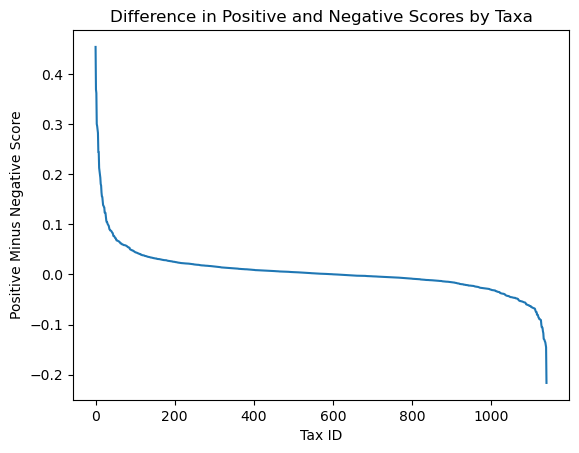

In [120]:
plt.plot(negative_to_positive_shift.values())
plt.title("Difference in Positive and Negative Scores by Taxa")
plt.xlabel("Tax ID")
plt.ylabel("Positive Minus Negative Score")

In [121]:
for model_name in ranked_taxa_by_positivity:
    print(model_name, "(Normalized Scores)")
    print("Positive:")
    display(ranked_taxa_by_positivity[model_name]["positive"][:50])
    print("Negative:")
    display(ranked_taxa_by_positivity[model_name]["negative"][:50])
    print("\n\n")

SetBERT (150-length) (Normalized Scores)
Positive:


,Kingdom,Phylum,Class,Order,Family,Genus,Attention Score
0,Bacteria,Firmicutes,Bacilli,Bacillales,Family_XII,Exiguobacterium,1.116425
1,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,Paenarthrobacter,0.982000
2,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillales_unclassified,Bacillales_unclassified,0.928913
3,Bacteria,Firmicutes,Bacilli,Lactobacillales,Enterococcaceae,Vagococcus,0.865479
4,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Massilia,0.804403
5,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Luteimonas,0.799223
6,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Morganella,0.750261
7,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Thermomonas,0.681629
8,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,0.592138
9,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,SC-I-84,SC-I-84_unclassified,0.511560


Negative:


,Kingdom,Phylum,Class,Order,Family,Genus,Attention Score
0,Bacteria,Firmicutes,Bacilli,Bacillales,Family_XII,Exiguobacterium,0.872381
1,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Massilia,0.848348
2,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillales_unclassified,Bacillales_unclassified,0.639760
3,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Luteimonas,0.593536
4,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Thermomonas,0.577179
5,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,0.559812
6,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,Paenarthrobacter,0.527911
7,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Morganella,0.506006
8,Bacteria,Firmicutes,Bacilli,Lactobacillales,Enterococcaceae,Vagococcus,0.503501
9,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Dermacoccaceae,Flexivirga,0.465748





SetBERT (Shallow-Trained, 150-length) (Normalized Scores)
Positive:


,Kingdom,Phylum,Class,Order,Family,Genus,Attention Score
0,Bacteria,Bacteroidetes,Bacteroidia,Flavobacteriales,Weeksellaceae,Chryseobacterium,0.394114
1,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,0.260144
2,Bacteria,Chloroflexi,Chloroflexia,Thermomicrobiales,JG30-KF-CM45,JG30-KF-CM45_unclassified,0.163726
3,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,Acinetobacter,0.155875
4,Bacteria,Bacteroidetes,Bacteroidia,Flavobacteriales,Flavobacteriaceae,Flavobacterium,0.149390
5,Bacteria,Planctomycetes,Planctomycetacia,Isosphaerales,Isosphaeraceae,Singulisphaera,0.139120
6,Bacteria,Bacteroidetes,Bacteroidia,Chitinophagales,Chitinophagaceae,Chitinophagaceae_unclassified,0.134626
7,Bacteria,Bacteroidetes,Bacteroidia,Sphingobacteriales,Sphingobacteriaceae,Mucilaginibacter,0.125904
8,Bacteria,Planctomycetes,Planctomycetacia,Isosphaerales,Isosphaeraceae,Isosphaeraceae_unclassified,0.122235
9,Bacteria,Bacteroidetes,Bacteroidia,Cytophagales,Spirosomaceae,Spirosoma,0.119702


Negative:


,Kingdom,Phylum,Class,Order,Family,Genus,Attention Score
0,Bacteria,Bacteroidetes,Bacteroidia,Flavobacteriales,Weeksellaceae,Chryseobacterium,0.411732
1,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,0.341448
2,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Moraxellaceae,Acinetobacter,0.228147
3,Bacteria,Bacteroidetes,Bacteroidia,Flavobacteriales,Flavobacteriaceae,Flavobacterium,0.142343
4,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,0.140914
5,Bacteria,Bacteroidetes,Bacteroidia,Sphingobacteriales,Sphingobacteriaceae,Mucilaginibacter,0.137583
6,Bacteria,Planctomycetes,Planctomycetacia,Isosphaerales,Isosphaeraceae,Singulisphaera,0.133545
7,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillales_unclassified,Bacillales_unclassified,0.130540
8,Bacteria,Planctomycetes,Planctomycetacia,Isosphaerales,Isosphaeraceae,Isosphaeraceae_unclassified,0.129048
9,Bacteria,Bacteroidetes,Bacteroidia,Sphingobacteriales,Sphingobacteriaceae,Pedobacter,0.125015


### Manuscript Tables

In [183]:
ranked_taxa_by_positivity[model_name]["positive"][-10:].to_csv(figure_path / "taxa_positive_lowest_normalized.csv")

In [186]:
model_name = "SetBERT (150-length)"
print(model_name, "(Normalized Scores)")
print("Positive:")
display(ranked_taxa_by_positivity[model_name]["positive"][:10])
display(ranked_taxa_by_positivity[model_name]["positive"][-10:])
ranked_taxa_by_positivity[model_name]["positive"][:10].to_csv(figure_path / "taxa_positive_highest_normalized.csv")
ranked_taxa_by_positivity[model_name]["positive"][-10:].to_csv(figure_path / "taxa_positive_lowest_normalized.csv")
print("Negative:")
display(ranked_taxa_by_positivity[model_name]["negative"][:10])
display(ranked_taxa_by_positivity[model_name]["negative"][-10:])
ranked_taxa_by_positivity[model_name]["negative"][:10].to_csv(figure_path / "taxa_negative_highest_normalized.csv")
ranked_taxa_by_positivity[model_name]["negative"][-10:].to_csv(figure_path / "taxa_negative_lowest_normalized.csv")
print("\n\n")

SetBERT (150-length) (Normalized Scores)
Positive:


,Kingdom,Phylum,Class,Order,Family,Genus,Attention Score
0,Bacteria,Firmicutes,Bacilli,Bacillales,Family_XII,Exiguobacterium,1.116425
1,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,Paenarthrobacter,0.982000
2,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillales_unclassified,Bacillales_unclassified,0.928913
3,Bacteria,Firmicutes,Bacilli,Lactobacillales,Enterococcaceae,Vagococcus,0.865479
4,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Massilia,0.804403
5,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Luteimonas,0.799223
6,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Morganella,0.750261
7,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Thermomonas,0.681629
8,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,0.592138
9,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,SC-I-84,SC-I-84_unclassified,0.511560


,Kingdom,Phylum,Class,Order,Family,Genus,Attention Score
1130,Bacteria,Planctomycetes,Phycisphaerae,Tepidisphaerales,WD2101_soil_group,WD2101_soil_group_unclassified,-0.546532
1131,Bacteria,Verrucomicrobia,Verrucomicrobiae,Chthoniobacterales,Chthoniobacteraceae,Chthoniobacter,-0.546577
1132,Bacteria,Acidobacteria,Acidobacteriia,Solibacterales,Solibacteraceae_,Bryobacter,-0.559778
1133,Bacteria,Proteobacteria,Alphaproteobacteria,Acetobacterales,Acetobacteraceae,Acetobacteraceae_unclassified,-0.565534
1134,Bacteria,Proteobacteria,Alphaproteobacteria,Acetobacterales,Acetobacteraceae,Roseomonas,-0.593619
1135,Bacteria,Actinobacteria,Acidimicrobiia,IMCC26256,IMCC26256_fa,IMCC26256_unclassified,-0.603151
1136,Bacteria,Actinobacteria,Thermoleophilia,Solirubrobacterales,67-14,67-14_unclassified,-0.614373
1137,Bacteria,Planctomycetes,Planctomycetacia,Isosphaerales,Isosphaeraceae,Isosphaeraceae_unclassified,-0.754144
1138,Bacteria,Chloroflexi,KD4-96,KD4-96_or,KD4-96_fa,KD4-96_unclassified,-0.763350
1139,Bacteria,Planctomycetes,Planctomycetacia,Isosphaerales,Isosphaeraceae,Singulisphaera,-0.886073


Negative:


,Kingdom,Phylum,Class,Order,Family,Genus,Attention Score
0,Bacteria,Firmicutes,Bacilli,Bacillales,Family_XII,Exiguobacterium,0.872381
1,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Massilia,0.848348
2,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillales_unclassified,Bacillales_unclassified,0.639760
3,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Luteimonas,0.593536
4,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Thermomonas,0.577179
5,Bacteria,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,0.559812
6,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Micrococcaceae,Paenarthrobacter,0.527911
7,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Morganella,0.506006
8,Bacteria,Firmicutes,Bacilli,Lactobacillales,Enterococcaceae,Vagococcus,0.503501
9,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Dermacoccaceae,Flexivirga,0.465748


,Kingdom,Phylum,Class,Order,Family,Genus,Attention Score
1140,Bacteria,Planctomycetes,Planctomycetacia,Isosphaerales,Isosphaeraceae,Aquisphaera,-0.540207
1141,Bacteria,Proteobacteria,Alphaproteobacteria,Acetobacterales,Acetobacteraceae,Roseomonas,-0.547437
1142,Bacteria,Acidobacteria,Acidobacteriia,Solibacterales,Solibacteraceae_,Bryobacter,-0.557227
1143,Bacteria,Planctomycetes,Phycisphaerae,Tepidisphaerales,WD2101_soil_group,WD2101_soil_group_unclassified,-0.561801
1144,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Rubritaleaceae,Luteolibacter,-0.566345
1145,Bacteria,Actinobacteria,Acidimicrobiia,IMCC26256,IMCC26256_fa,IMCC26256_unclassified,-0.615847
1146,Bacteria,Actinobacteria,Thermoleophilia,Solirubrobacterales,67-14,67-14_unclassified,-0.653290
1147,Bacteria,Chloroflexi,KD4-96,KD4-96_or,KD4-96_fa,KD4-96_unclassified,-0.716633
1148,Bacteria,Planctomycetes,Planctomycetacia,Isosphaerales,Isosphaeraceae,Isosphaeraceae_unclassified,-0.779521
1149,Bacteria,Planctomycetes,Planctomycetacia,Isosphaerales,Isosphaeraceae,Singulisphaera,-0.883272
